___
# Proyecto 4: Informe Final Carrera
## Mejora en el TP3. Obtención de datos hidroclimáticos & entrenamiento de una red neuronal LSTM
___

Presentado por [David Serna Gutiérrez](https://www.linkedin.com/in/dserna-g94/).

Notebook disponible en el repositorio de Git-Hub: [https://github.com/dsernag/ACAMICA-DS-ONLINE-33](https://github.com/dsernag/ACAMICA-DS-ONLINE-33)

Ingeniero Forestal de la Universidad Nacional de Colombia Sede Medellín

Estudiante de Especialización en Sistemas de Información Geográfica

*© Todos los derechos reservados*

___

### OBJETIVO
___

El presente notebook continúa el análisis realizado en el TP3 sobre datos de [dengue](http://medata.gov.co/dataset/dengue). Los cuales corresponden al registro de pacientes atendidos en las Instituciones Prestadoras de Servicios de Salud con diagnóstico probable o confirmado de Dengue y notificados al Sistema Nacional de Vigilancia en Salud Pública (SIVIGILA) desde el año 2008 al 2018.

Se pretende realizar web scraping al portal de descargas del "Sistema de Alerta Temprana de Medellín y el Valle de Aburrá" ([SIATA](https://siata.gov.co/descarga_siata/index.php/index2/login)). Allí hay acceso a toda la información. Cómo insumo del trabajo se descargará precipitación y temperatura. Es necesario crear una cuenta para acceder al portal, es completamente gratuito y expedito.

Luego de recolectar la información se debe realizar una depuración de los mismos, pues el portal genera 1 archivo *.csv* para cada mes de cada estación. Así, sí queremos información de 2008 a 2018, serían 11 años por 12 meses por el número de estaciones que se quieren, para 10 estaciones serían 1.320 csv. Esto igual para los datos de temperatura.

Finalmente con los datos organizados y resumidos a resolución semanal, se repetirá el diseño de features, el análisis de correlaciones y se ensayarán 3 modelos; un modelo persistente (donde el valor anterior 't-1' predecira el siguiente valor 't') como benchmark, una red neuronal LSTM univariada (únicamente con los casos de dengue) y nuevamente una red neuronal LSTM multivariada, tomando como insumos las variables hidroclimáticas. Teniendo estos tres modelos se pretende evaluar la efectividad e influencia que puedan tener las variables hidroclimáticas en la predicción de casos de dengue.

### HIPÓTESIS

* Los casos de dengue tienen algún nivel de correlación con las variables hidroclimáticas 
* Es posible mejorar las estimaciones de cualquier tipo de modelo agregando información hidroclimática
* La red neuronal deberá tener mejor score (RMSE menor) que el modelo de persistencia
___

## SECCIÓN 1) DESCARGA DE INFORMACIÓN

___

### 1.1) ESTACIONES HIDROCLIMÁTICAS
___

El SIATA brinda acceso a los datos de manera gratuita a cualquiera que cree una cuenta en su servidor justifique con mínimo 10 palabras el propósito de su descarga. Existe una variedad de información como precipitación, temperatura, material particulado, nivel de ríos y quebradas. Expresada esta diversidad de información, es evidente la diversidad en equipamentos para cada estación. Cada estación es diferente y puede tener o no ciertos instrumentos para medir uno u otro fenómeno.

En las siguientes líneas de código resuelvo escoger únicamente las estaciones que estén activas, que su fecha de instalación sea antes de 2011 y que estén dentro del perímetro urbano de Medellín (El SIATA abarca toda el Área Metropolitana del Valle de Aburrá, que son 10 municipios, del que Medellín es uno.

In [20]:
#El siguiente enlace lleva a un archivo csv donde están en teoría las 688 estaciones
estaciones_coords = pd.read_csv("https://siata.gov.co/descarga_siata//application/assets/assets-siata/coordenadas/Estaciones_Meteorologicas.csv", encoding="latin-1")
#estaciones_coords.to_csv('estaciones_SIATA.csv')

In [24]:
print(estaciones_coords.shape)
estaciones_coords.head()

(688, 11)


,Codigo,Estacion,Longitud,Latitud,Ciudad,Barrio,Comuna,Corregimiento,Vereda,Fecha_Instalacion,Estado
0,1,Casa de Gobierno Altavista,-75.62820,6.22260,Medellin,NaN,NaN,70 Altavista,Altavista - Sector central,2009-11-19,Activa
1,2,Escuela Rural La Verde,-75.64069,6.18686,Medellin,NaN,NaN,80 San Antonio de Prado,La Verde,2009-11-12,Activa
2,3,Escuela Rural Yarumalito,-75.69426,6.23309,Medellin,NaN,NaN,80 San Antonio de Prado,Yarumalito,2009-11-12,Activa
3,4,I.E Hector Rogelio Montoya,-75.69080,6.34309,Medellin,NaN,NaN,50 Palmitas,Palmitas - Sector Central,2009-11-26,Activa
4,5,I.E Santa Elena,-75.49214,6.20621,Medellin,NaN,NaN,90 Santa Elena,Santa Elena Sector Central,2009-11-13,Activa


In [25]:
#Pasamos las 'fecha_instalacion' a objeto datetime64:
estaciones_coords['Fecha_Instalacion']=pd.to_datetime(estaciones_coords.Fecha_Instalacion)
estaciones_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Codigo             688 non-null    int64         
 1   Estacion           688 non-null    object        
 2   Longitud           688 non-null    float64       
 3   Latitud            688 non-null    float64       
 4   Ciudad             687 non-null    object        
 5   Barrio             317 non-null    object        
 6   Comuna             202 non-null    object        
 7   Corregimiento      84 non-null     object        
 8   Vereda             224 non-null    object        
 9   Fecha_Instalacion  674 non-null    datetime64[ns]
 10  Estado             688 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 59.2+ KB


Chequeamos los valores max y min de la fecha de instalación:

In [26]:
warnings.filterwarnings('ignore')
estaciones_coords.describe(include='all')

,Codigo,Estacion,Longitud,Latitud,Ciudad,Barrio,Comuna,Corregimiento,Vereda,Fecha_Instalacion,Estado
count,688.000000,688,688.000000,688.000000,687,317,202,84,224,674,688
unique,NaN,672,NaN,NaN,53,158,30,13,113,413,2
top,NaN,Escuela CEDEPRO,NaN,NaN,Medellin,Estadio,11 Laureles - Estadio,90 Santa Elena,El Plan,2019-12-23 00:00:00,Activa
freq,NaN,3,NaN,NaN,262,24,27,26,9,21,567
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-01-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-24 00:00:00,NaN
mean,31273.424419,NaN,-75.249484,6.217160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,46216.660952,NaN,4.987580,0.714353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,-76.685710,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,176.750000,NaN,-75.633290,6.158140,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
#Creamos el objeto como un objeto espacial
stations_geo = gpd.GeoDataFrame(estaciones_coords, geometry=gpd.points_from_xy(estaciones_coords.Longitud, estaciones_coords.Latitud),crs={'init': 'epsg:4326'})

Se observa que hay unas fechas con el año 1999, lo cual considero error, pues de antemano conozoco que en 2010 el SIATA se consolidó, casi todas sus estaciones comenzaron a funcionar entre 2009-2011

In [209]:
estaciones_activas = stations_geo.loc[(stations_geo.Estado=='Activa') & 
                                           (stations_geo.Fecha_Instalacion <= '2011') & 
                                           (stations_geo.Fecha_Instalacion > '2000')]

In [31]:
print(f"Para nuestro análisis preliminar quedamos con {estaciones_activas.shape[0]} estaciones para toda el Área Metropolitana")

Para nuestro análisis preliminar quedamos con 45 estaciones para toda el Área Metropolitana


___

De esas 45 estaciones es necesario que estén dentro del área Urbana de Medellín:

In [35]:
#Leemos la capa de Medellín en CRS WGS1984
import geopandas as gpd

medellin = gpd.read_file("capas/medellin.shp")
AMVA = gpd.read_file("capas/AMVA.shp")

In [38]:
AMVA

,OBJECTID,NMG,DANE_M,SHAPE_Leng,SHAPE_Area,geometry
0,21,Barbosa,5079,82614.894347,2.062969e+08,"POLYGON ((-75.24552 6.50157, -75.24541 6.50154..."
1,22,Girardota,5308,43926.385392,8.158480e+07,"POLYGON ((-75.45106 6.43674, -75.45106 6.43674..."
2,23,Copacabana,5212,52992.388963,6.963980e+07,"POLYGON ((-75.53259 6.38887, -75.53246 6.38891..."
3,24,Bello,5088,60261.778817,1.414062e+08,"POLYGON ((-75.66767 6.37441, -75.66745 6.37470..."
4,26,Medellín,5001,108927.952274,3.754912e+08,"POLYGON ((-75.68375 6.36990, -75.68332 6.36985..."
5,28,Itagüí,5360,21115.100279,2.080166e+07,"POLYGON ((-75.58540 6.18662, -75.58550 6.18657..."
6,29,Envigado,5266,50057.411643,7.792813e+07,"POLYGON ((-75.48487 6.19147, -75.48478 6.19138..."
7,30,La Estrella,5380,29706.611305,3.499619e+07,"POLYGON ((-75.64513 6.16571, -75.64501 6.16570..."
8,31,Sabaneta,5631,18455.886818,1.635039e+07,"POLYGON ((-75.60512 6.16322, -75.60499 6.16308..."
9,32,Caldas,5129,57144.130934,1.347485e+08,"POLYGON ((-75.59046 6.11274, -75.59039 6.11265..."


A continuación grafico los 10 municipios del AMVA y las 45 esatciones

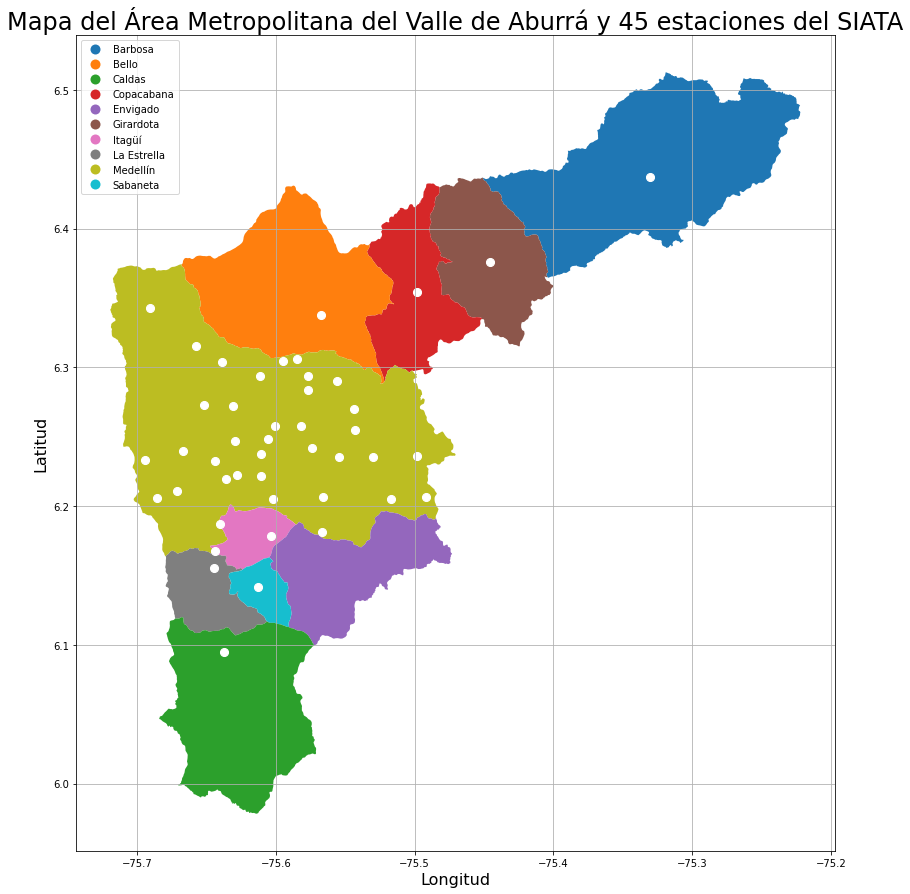

In [57]:
#Hacemos un pequeño gráfico:
import matplotlib.pyplot as plt

# A figure of all restaurants with background
fig, ax = plt.subplots(figsize=(15, 15))
AMVA.plot(ax=ax,column='NMG', legend=True, legend_kwds= {'loc':'upper left'} )
plt.title('Mapa del Área Metropolitana del Valle de Aburrá y 45 estaciones del SIATA',size=24)
plt.xlabel('Longitud', size = 16)
plt.ylabel('Latitud', size = 16)
stations_geo.geometry.plot(ax=ax,markersize=65,color='white')
ax.grid(True)
plt.show()

No todas las estaciones seleccionadas están en el área urbana de Medellín, por lo que necesitamos los puntos que estén dentro de Medellín:

In [210]:
#Esto es para unificar el multipolígono a uno solo
medellin_capa = medellin.geometry.unary_union

#Realizamos una máscara booleana para encontrar cuáles estaciones están dentro de Medellín.
estaciones_medellin = estaciones_activas[estaciones_activas.within(medellin_capa)]

In [211]:
print(f"Finalmente me interesan {estaciones_medellin.shape[0]} estaciones. Éstas están dentro del polígono de Medellín!")

Finalmente me interesan 18 estaciones. Éstas están dentro del polígono de Medellín!


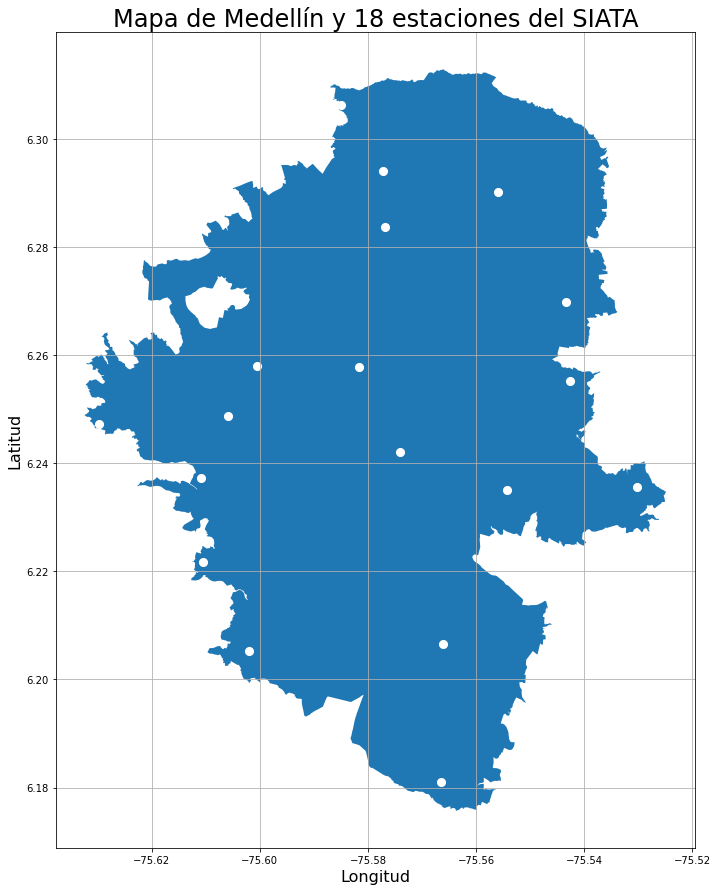

In [61]:
#Hacemos un pequeño gráfico:
import matplotlib.pyplot as plt

# A figure of all restaurants with background
fig, ax = plt.subplots(figsize=(15, 15))
medellin.plot(ax=ax)
plt.title('Mapa de Medellín y 18 estaciones del SIATA',size=24)
plt.xlabel('Longitud', size = 16)
plt.ylabel('Latitud', size = 16)
estaciones_medellin.geometry.plot(ax=ax,markersize=65,color='white')
ax.grid(True)
plt.show()

Con `estaciones_medellin` podemos continuar, pues así, independiente de la variable hidroclimática o ambiental que busquemos, se puede filtrar que esté en esta lista de 18. Hay que recordar que son solo 18 estaciones, pues en el trasegar de los años se han instalado más estaciones para diferentes propósitos, pero para analizar los datos de dengue de 2008 a 2018, requiero que sean incluso desde 2008 (los cuales no existen). Estas 18 lo más seguro es que sean hidroclimáticas únicamente, y su calidad inicial puede no ser muy buena.

___

### 1.2) WEB SCRAPING PRECIPITACIÓN
___

El primer paso es configurar la librería de Selenium para que corra a la perfección el driver de Chrome, ubicado en la carpeta específica:
___

In [199]:
#Importar la librería de Selenium y permitir el complemento de chrome para hacer el web scraping
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
import timeit
warnings.filterwarnings('ignore')


sys.path.insert(0,'C:\PY_ENV\Selenium')

chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
SIATA = webdriver.Chrome(chrome_options=chrome_options, executable_path= r"C:\PY_ENV\Selenium\chromedriver.exe")

#Acá solicitamos que a nuestro driver se cargue la página del SIATA
SIATA.get('https://siata.gov.co/descarga_siata/index.php/index2/login')

___
Accedemos las credenciales para ingresar al portal:

In [112]:
#Luego de abierto el navegador le damos las siguientes indicaciones para acceder a la base de datos:
#Accedemos a la página web:
SIATA.find_element_by_id("usuario").click()
SIATA.find_element_by_id("usuario").clear()
#Usuario
SIATA.find_element_by_id("usuario").send_keys("****")
SIATA.find_element_by_id("contrasena").click()
SIATA.find_element_by_id("contrasena").clear()
#Contraseña
SIATA.find_element_by_id("contrasena").send_keys("****")
SIATA.find_element_by_id("login_form").click()
#Ingreso
SIATA.find_element_by_id("Ingresar").click()

___
Verifiquemos cuáles son los botones disponibles:

In [113]:
#Mediante esta selección buscamos los elementos:
portada_html = BeautifulSoup(SIATA.page_source)
menu_izquierdo = portada_html.find_all('li',class_= "panel")
botones = []
for boton_menu in menu_izquierdo:
    botones.append(boton_menu.get('id'))

In [114]:
botones

['menu_radar',
 'menu_estaciones',
 'menu_hidro',
 'menu_calaire',
 'menu_calaire_anual',
 'menu_acelero',
 'menu_graficador',
 'menu_info_radar',
 'menu_info_estac',
 'menu_info_pluviomet',
 'menu_info_nivel',
 'menu_info_aire',
 'menu_contactenos']

___
En mi caso me interesan `menu_estaciones`:

In [115]:
#Seleccionamos las Estaciones Meteorológicas:
SIATA.find_element_by_xpath("//li[@id='menu_estaciones']/a/font").click()

___
Completamos los campos de "Motivo de descarga" y las fechas:

In [116]:
#Dado que el SIATA pide un motivo de descarga, creamos un objeto de texto con la justificación y lo ingresamos:
motivo= "Se necesita calcular en Medellín la precipitación a nivel de barrio a una escala mensual. Soy estudiante de la Especialización en SIG de la Universidad Nacional de Colombia Sede Medellín."

#Le damos click, limpiamos el campo y mandamos el texto que queremos
SIATA.find_element_by_id("motivo_descarga").click()
SIATA.find_element_by_id("motivo_descarga").clear()
SIATA.find_element_by_id("motivo_descarga").send_keys(motivo)

#Ahora para las fechas igualmente:
#Recordemos que fechas anteriores no existen, pues en general las estaciones funcionan desde 2010
fecha_inicio = "2010-01-01 00:00:00"
fecha_final = "2020-12-31 23:00:00"

#Los ingresamos:
SIATA.find_element_by_id("datetimepicker").click()
SIATA.find_element_by_id("datetimepicker").clear()
SIATA.find_element_by_id("datetimepicker").send_keys(fecha_inicio)
SIATA.find_element_by_id("datetimepicker2").click()
SIATA.find_element_by_id("datetimepicker2").clear()
SIATA.find_element_by_id("datetimepicker2").send_keys(fecha_final)

___
En las estaciones hidroclimáticas se puede escoger entre Humedad, Precipitación, Presión, Temperatura, Viento y Radación. Intentaré acceder a cada una

In [130]:
hidroclima_html = BeautifulSoup(SIATA.page_source)
datos_hidroclima = hidroclima_html.find_all('input',type= "radio")
botones_hidroclima = []

for datos in datos_hidroclima[0:-2]:
    botones_hidroclima.append(datos.get('value'))
    
hidroclima =pd.DataFrame({'botones':botones_hidroclima,
                          'contador_div': [i for i in range(2,8)]})

In [132]:
#Con ayuda de Katalon logré entender que depende de la variable que se quiera, depende de la organización de la div en la página, así:
hidroclima

,botones,contador_div
0,Humedad,2
1,Precipitacion,3
2,Presion,4
3,Temperatura,5
4,Vientos,6
5,Radiacion,7


In [191]:
#Sí quiero Precipitación debo usar el 3:
variable = 'Precipitacion'
variable_hidroclima = hidroclima[hidroclima.botones == variable].contador_div.values[0]

In [192]:
SIATA.find_element_by_xpath("//form[@id='estaciones_form']/div[2]/div/label["+str(variable_hidroclima)+"]").click()

___
Se deben seleccionar las estaciones que queremos descargar. El siguiente script accede al código de cada estación:

In [193]:
#Ahora necesitamos seleccionar las estaciones deseadas, así que primero debo obtener la lista de estaciones por número para decirle a cuáles clikear
from bs4 import BeautifulSoup
html_meteo = BeautifulSoup(SIATA.page_source)

#html_SIATA
#Con base en la estructura del SIATA sabemos que para encontrar las estaciones:
estaciones_html = SIATA.find_elements_by_class_name("select-all-class")

#Ahora debemos iterar sobre esta lista de estaciones para obtenerla
estaciones = []
for est in estaciones_html:
    estaciones.append(est.get_attribute('value'))
    
estaciones_web = pd.DataFrame(estaciones,columns=['estacion'])
estaciones_web['indice'] = np.array(range(1,(len(estaciones_web)+1)))
estaciones_web['estacion']=estaciones_web.estacion.astype(int)

El Data Set `estaciones_web` tiene en "Estacion" el número de la estación y en "indice" corresponde al elemento en html que corresponde a la casilla de verificación para seleccionar las estaciones que se necesita, por lo tanto, las estaciones que necesitamos es `estaciones_medellin`. Así que hagamos una pequeña máscara:

In [194]:
estaciones_forloop =estaciones_web[estaciones_web.estacion.isin(estaciones_medellin.Codigo)]

In [195]:
estaciones_forloop

,estacion,indice
5,7,6
7,9,8
10,12,11
11,15,12
12,16,13
13,17,14
18,22,19
19,23,20
20,24,21
24,28,25


Corremos un for que interactué por esos índices para seleccionar las estaciones que necesitamos:

In [196]:
#Ahora debo iterar sobre cada caja para seleccionar las primeras 48 estaciones
for i in estaciones_forloop.indice:
    SIATA.find_element_by_xpath("(//input[@id='checkEst'])"+"["+str(i)+"]").click()

Se realiza la consulta:

In [198]:
%%time
#Concretamos nuestra búsqueda:
SIATA.set_page_load_timeout(600)
SIATA.find_element_by_id("realizarConsulta").click()

Wall time: 5min


Extraemos una lista con cada csv:

In [22]:
#A partir de este punto necesitamos extraer todos los enlaces que se obtuvieron:
html_SIATA = BeautifulSoup(SIATA.page_source)
descarga = html_SIATA.find_all('a',class_= "btn btn-info")

#Iteramos sobre ellos y le pedimos que nos devuelva el "href" que es el enlace de la descarga:
lista_descarga = []
for des in descarga:
    lista_descarga.append(des.get('href'))
print(f"La cantidad total de datasets es: {len(lista_descarga)}")

La cantidad total de datasets es: 2227


Descarga por urlib (+rápido)

In [21]:
%%time
import urllib.request
import timeit

for enlace in lista_descarga:
    urllib.request.urlretrieve(enlace, ("SIATA_downloads/preci/"+enlace.split("/")[-1]))

Wall time: 17min 15s


Tengo todos los data_sets para continuar el análisis! Pero antes, temperatura:

___
### 1.3) WEB SCRAPING TEMPERATURA
___

En este caso el proceso es muy similar, la diferencia es que seleccionaremos temperatura, y saber que las estaciones de temperatura son posteriores a 2010:

In [231]:
estaciones_activas_temp = stations_geo.loc[(stations_geo.Estado=='Activa') & 
                                           (stations_geo.Fecha_Instalacion <= '2014') & 
                                           (stations_geo.Fecha_Instalacion > '2000')]


estaciones_medellin_temp = estaciones_activas_temp[estaciones_activas_temp.within(medellin_capa)]

In [232]:
print(estaciones_medellin_temp.shape)
estaciones_medellin_temp.head()

(44, 12)


,Codigo,Estacion,Longitud,Latitud,Ciudad,Barrio,Comuna,Corregimiento,Vereda,Fecha_Instalacion,Estado,geometry
6,7,Escuela Republica de Cuba,-75.57721,6.29397,Medellin,La Esperanza,06 Doce Octubre,NaN,NaN,2009-11-17,Activa,POINT (-75.57721 6.29397)
8,9,Instituto Pedro Justo Berrio,-75.61093,6.23728,Medellin,Las Mercedes,16 Belen,NaN,NaN,2009-11-20,Activa,POINT (-75.61093 6.23728)
11,12,I.E Concejo de Medellin,-75.60050,6.25800,Medellin,La Floresta,12 La America,NaN,NaN,2009-11-23,Activa,POINT (-75.60050 6.25800)
13,14,Escuela El Triunfo,-75.58491,6.30634,Medellin,El Triunfo,06 Doce Octubre,NaN,NaN,2009-11-23,Activa,POINT (-75.58491 6.30634)
14,15,Colegio San Lucas,-75.56653,6.18100,Medellin,San Lucas,14 El Poblado,NaN,NaN,2009-12-17,Activa,POINT (-75.56653 6.18100)


Ahora hay el doble de estaciones en Medellín al cambiar la restricción de la fecha de instalación!

In [238]:
#Importar la librería de Selenium y permitir el complemento de chrome para hacer el web scraping
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
import timeit
warnings.filterwarnings('ignore')


sys.path.insert(0,'C:\PY_ENV\Selenium')

chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
SIATA = webdriver.Chrome(chrome_options=chrome_options, executable_path= r"C:\PY_ENV\Selenium\chromedriver.exe")

#Acá solicitamos que a nuestro driver se cargue la página del SIATA
SIATA.get('https://siata.gov.co/descarga_siata/index.php/index2/login')

___
Accedemos las credenciales para ingresar al portal:

In [239]:
#Luego de abierto el navegador le damos las siguientes indicaciones para acceder a la base de datos:
#Accedemos a la página web:
SIATA.find_element_by_id("usuario").click()
SIATA.find_element_by_id("usuario").clear()
#Usuario
SIATA.find_element_by_id("usuario").send_keys("dsernag94")
SIATA.find_element_by_id("contrasena").click()
SIATA.find_element_by_id("contrasena").clear()
#Contraseña
SIATA.find_element_by_id("contrasena").send_keys("(VOYAL)colegio.")
SIATA.find_element_by_id("login_form").click()
#Ingreso
SIATA.find_element_by_id("Ingresar").click()

___
Seleccionamos el botón igual que el anterior:

In [221]:
botones

['menu_radar',
 'menu_estaciones',
 'menu_hidro',
 'menu_calaire',
 'menu_calaire_anual',
 'menu_acelero',
 'menu_graficador',
 'menu_info_radar',
 'menu_info_estac',
 'menu_info_pluviomet',
 'menu_info_nivel',
 'menu_info_aire',
 'menu_contactenos']

___
En mi caso me interesan `menu_estaciones`:

In [240]:
#Seleccionamos las Estaciones Meteorológicas:
SIATA.find_element_by_xpath("//li[@id='menu_estaciones']/a/font").click()

___
Completamos los campos de "Motivo de descarga" y las fechas:

In [241]:
#Dado que el SIATA pide un motivo de descarga, creamos un objeto de texto con la justificación y lo ingresamos:
motivo= "Se necesita calcular en Medellín la precipitación a nivel de barrio a una escala mensual. Soy estudiante de la Especialización en SIG de la Universidad Nacional de Colombia Sede Medellín."

#Le damos click, limpiamos el campo y mandamos el texto que queremos
SIATA.find_element_by_id("motivo_descarga").click()
SIATA.find_element_by_id("motivo_descarga").clear()
SIATA.find_element_by_id("motivo_descarga").send_keys(motivo)

#Ahora para las fechas igualmente:
#Recordemos que fechas anteriores no existen, pues en general las estaciones funcionan desde 2010
fecha_inicio = "2010-01-01 00:00:00"
fecha_final = "2020-12-31 23:00:00"

#Los ingresamos:
SIATA.find_element_by_id("datetimepicker").click()
SIATA.find_element_by_id("datetimepicker").clear()
SIATA.find_element_by_id("datetimepicker").send_keys(fecha_inicio)
SIATA.find_element_by_id("datetimepicker2").click()
SIATA.find_element_by_id("datetimepicker2").clear()
SIATA.find_element_by_id("datetimepicker2").send_keys(fecha_final)

___
En las estaciones hidroclimáticas se puede escoger entre Humedad, Precipitación, Presión, Temperatura, Viento y Radación. Intentaré acceder a cada una

In [242]:
hidroclima_html = BeautifulSoup(SIATA.page_source)
datos_hidroclima = hidroclima_html.find_all('input',type= "radio")
botones_hidroclima = []

for datos in datos_hidroclima[0:-2]:
    botones_hidroclima.append(datos.get('value'))
    
hidroclima =pd.DataFrame({'botones':botones_hidroclima,
                          'contador_div': [i for i in range(2,8)]})

In [243]:
#Con ayuda de Katalon logré entender que depende de la variable que se quiera, depende de la organización de la div en la página, así:
hidroclima

,botones,contador_div
0,Humedad,2
1,Precipitacion,3
2,Presion,4
3,Temperatura,5
4,Vientos,6
5,Radiacion,7


In [245]:
#Sí quiero Precipitación debo usar el 3:
variable = 'Temperatura'
variable_hidroclima = hidroclima[hidroclima.botones == variable].contador_div.values[0]
SIATA.find_element_by_xpath("//form[@id='estaciones_form']/div[2]/div/label["+str(variable_hidroclima)+"]").click()

___
Se deben seleccionar las estaciones que queremos descargar. El siguiente script accede al código de cada estación:

In [246]:
#Ahora necesitamos seleccionar las estaciones deseadas, así que primero debo obtener la lista de estaciones por número para decirle a cuáles clikear
from bs4 import BeautifulSoup
html_meteo = BeautifulSoup(SIATA.page_source)

#html_SIATA
#Con base en la estructura del SIATA sabemos que para encontrar las estaciones:
estaciones_html = SIATA.find_elements_by_class_name("select-all-class")

#Ahora debemos iterar sobre esta lista de estaciones para obtenerla
estaciones = []
for est in estaciones_html:
    estaciones.append(est.get_attribute('value'))
    
estaciones_web = pd.DataFrame(estaciones,columns=['estacion'])
estaciones_web['indice'] = np.array(range(1,(len(estaciones_web)+1)))
estaciones_web['estacion']=estaciones_web.estacion.astype(int)

El Data Set `estaciones_web` tiene en "Estacion" el número de la estación y en "indice" corresponde al elemento en html que corresponde a la casilla de verificación para seleccionar las estaciones que se necesita, por lo tanto, las estaciones que necesitamos es `estaciones_medellin`. Así que hagamos una pequeña máscara:

In [247]:
estaciones_forloop =estaciones_web[estaciones_web.estacion.isin(estaciones_activas_temp.Codigo)]

In [248]:
estaciones_forloop

,estacion,indice
0,59,1
1,68,2
2,73,3
3,82,4
4,83,5
10,201,11
11,202,12
12,203,13
13,205,14
14,206,15


Corremos un for que interactué por esos índices para seleccionar las estaciones que necesitamos:

In [249]:
#Ahora debo iterar sobre cada caja para seleccionar las primeras 48 estaciones
for i in estaciones_forloop.indice:
    SIATA.find_element_by_xpath("(//input[@id='checkEst'])"+"["+str(i)+"]").click()

Se realiza la consulta:

In [250]:
%%time
#Concretamos nuestra búsqueda:
#SIATA.set_page_load_timeout(600)
SIATA.find_element_by_id("realizarConsulta").click()

Wall time: 5.15 s


Extraemos una lista con cada csv:

In [251]:
#A partir de este punto necesitamos extraer todos los enlaces que se obtuvieron:
html_descarga = BeautifulSoup(SIATA.page_source)
descarga = html_descarga.find_all('a',class_= "btn btn-info")

#Iteramos sobre ellos y le pedimos que nos devuelva el "href" que es el enlace de la descarga:
lista_descarga = []
for des in descarga:
    lista_descarga.append(des.get('href'))
print(f"La cantidad total de datasets es: {len(lista_descarga)}")

La cantidad total de datasets es: 1090


Descarga por urlib (+rápido)

In [256]:
%%time
import urllib.request
import timeit

for enlace in lista_descarga:
    urllib.request.urlretrieve(enlace, ("SIATA_downloads/temp/"+enlace.split("/")[-1]))

Wall time: 12min 47s


Tengo todos los data_sets para continuar el análisis!

___
## SECCIÓN 2) DEPURACIÓN DE LA INFORMACIÓN
____

Básicamente se acaban de descargar 3.93 Gigabytes ([Apoyado en este recurso](https://codezup.com/calculate-and-display-directory-size-python/)) de información. Dependiendo del tipo de información, varía la estación, e incluso entre estaciones varía la resolución temporal, algunas dan el dato cada minuto, otrás cada 5 y otras cada 10. Es necesario por ende realizar lo siguiente en cada tipo de dato, para precipitación y temperatura:

* Leer como una lista los archivos que están en las carpetas de descarga
* Crear un DataFrame de pandas donde se irán concatenando cada archivo abierto
* Correr un for que abra cada archivo *.csv* de la lista
* A cada archivo abierto:
    * Verificar que no esté vacío el CSV
    * Quitar cualquier valor nulo
    * En la precipitación hay *.csv* con 3 o 4 columnas, sí tiene 4, que elimine "P2"
    * Según la [documentación del SIATA] (https://siata.gov.co/descarga_siata/application/assets/assets-siata/pdf/generalidades/Generalidades_Info_Pluvio_Meteo.pdf) hay una columna llamada `Calidad`, valores entre 151,1512 y 2 deben ser eliminados.
    * Deben ser eliminados también valores de precipitación o temperatura que tengan -999
    * Asignar una columna con el número de la estación
    * Resamplear a nivel de día (Para la temperatura es posible encontrar los valores máximos, mínimos y medios por día!
* Concatenar en la base de Pandas
* Seguir el for hasta terminar toda la lista

In [293]:
import os
HOME_FOLDER = os.getcwd() + "\\SIATA_downloads"
directory_size = 0
fsizedicr = {'Bytes': 1, 'Kilobytes': float(1)/1024, 'Megabytes': float(1)/(1024**2), 'Gigabytes': float(1)/(1024**3)}

for (path, dirs, files) in os.walk(HOME_FOLDER):
    for file in files:
        filename = os.path.join(path, file)
        directory_size += os.path.getsize(filename)

print ("Folder Size: " + str(round(fsizedicr['Gigabytes']*directory_size, 2)) + " " + key)

Folder Size: 3.93 Gigabytes


___
### 2.1) PRECIPITACIÓN
___

El siguiente código intenta llevar a realidad el pseudocódigo de arriba:

In [2]:
%%time
import sys
import os
import pandas as pd
import numpy as np
import timeit

#Definir la ruta de los datos:
ruta_proyecto = os.getcwd() + "\\SIATA_downloads\\preci"
#Lista de los archivos csv
lista_preci = os.listdir(ruta_proyecto)
#El data frame que recibirá todos los data_frames
preci_todas = pd.DataFrame()

#Corremos el for
for archivo in lista_preci:
    # Necesitamos la dirección concreta de cada archivo CSV para ser abierto:
    csv = (ruta_proyecto + "\\" + archivo)
    
    #Extraemos el número de la estación
    estacion = int(archivo.split("_")[3])
    
    #Leemos el archivo csv
    data_frame = pd.read_csv(csv, encoding='utf-8')
    
    #Se debe definir esta condición para no iterar sobre archivos vacíos
    if data_frame.shape[0] == 0:
        continue
    if data_frame.shape[1] == 4:
        data_frame.drop('P2',axis=1,inplace=True)
        data_frame.rename(columns = {'P1':'P'},inplace=True)
        
    #Ejecutamos la limpieza
    data_frame.dropna(inplace=True)  
    data_frame = data_frame[(~data_frame.Calidad.isin([151,152,2])) & (data_frame.P != -999)]
    data_frame['fecha_hora'] = pd.to_datetime(data_frame.fecha_hora)
    data_frame.drop('Calidad',axis = 1, inplace = True)
    
    #Nuevamente porque quedan archivos vacios
    if data_frame.shape[0] == 0:
        continue
        
    #Resampleamos:
    data2 = data_frame.resample('D', on = 'fecha_hora').sum().reset_index().dropna()
    #Eliminamos este data_frame para no ocupar más espacio
    del data_frame
    #Agregamos la estación
    data2['codigo'] = estacion
    #Concatenamos el csv final
    preci_todas = pd.concat([preci_todas.reset_index(drop=True), data2], axis=0)

Wall time: 2min 24s


In [3]:
print(preci_todas.shape)
preci_todas.head()
#Esta información es muy valiosa y será guardada como un csv para más adelante:
#preci_todas.to_csv('precipitacion_2010-2020.csv',index=False)

(56461, 3)


,fecha_hora,P,codigo
0,2010-11-28,0.000,12
1,2011-03-03,0.762,12
2,2011-03-04,0.762,12
3,2011-03-05,0.508,12
4,2011-03-06,6.096,12


Con la base de datos guardada, le asignamos el mismo nombre a la lectura del CSV. Ahora el objetivo es tener la misma resolución que el dengue, es decir mensual, sin embargo, como tenemos menos datos (por tener que reducir desde 2015) será mejor hacerlo a nivel semanal. Para ello es necesario correr un for donde se separe cada data_set por su código único y obtener un resampleo mensual donde se sume la precipitación y se encuentre el promedio y la desviación estándar!

In [4]:
preci_raw = pd.read_csv('precipitacion_2010-2020.csv', encoding = 'utf-8')
preci_raw['fecha_hora'] = pd.to_datetime(preci_raw.fecha_hora)

El siguiente FOR tiene incrustado un gráfico opcional para verificar la integridad de los datos.
Como se observa, hay unas estaciones con problemas. Al parecer se estabilizan luego del 2014, e incluso algunas siguen teniendo problemas.
## **¿Qué hacer?**
Sacaré los datos desde 2015!

In [5]:
%%time

preci_raw = preci_raw[(preci_raw.fecha_hora >= '2015')]

preci_mensual = pd.DataFrame()
for estacion in preci_raw.codigo.unique():
    #Separar por estación el set de datos:
    data = preci_raw[preci_raw.codigo == estacion]
    #Resamplear esa estación
    data2 = data.resample('W', on = 'fecha_hora').agg(['sum','mean','std']).reset_index()
    del data
        
    #Eliminar cualquier valor faltante:
    data2.dropna(inplace=True)
    #Cambiar los multiíndices:
    data2.columns = ['_'.join(col) for col in data2.columns.values]
    ########################################################################################
    #plt.figure(figsize=(24,10))
    #sns.lineplot(data=data2, x = 'fecha_hora_', y ='P_mean')
    #plt.ylabel('Precipitación mensual (mm)',size=16)
    #plt.xlabel('Fecha',size=16)
    #plt.vlines(x=pd.to_datetime('2015-01-01'),ymin=0,ymax=10,colors='red')
    #plt.title('Comportamiento de la precipitación media en la estacion '+str(estacion),fontsize=25)
    ########################################################################################
    #Concatenar a la base de datos grande
    preci_mensual = pd.concat([preci_mensual.reset_index(drop=True), data2], axis=0)

#Arreglo de las columnas
preci_mensual.drop(['codigo_sum','codigo_std'],axis=1,inplace=True)
preci_mensual.rename(columns = {'fecha_hora_':'fecha_hora',
                               'codigo_mean':'codigo'},inplace=True)

Wall time: 371 ms


In [6]:
#Remuestreo para obtener un promedio de la precipitación para cada mes con base en las 18 estaciones
precipitacion = preci_mensual.resample('W', on = 'fecha_hora').mean().reset_index().drop('codigo',axis=1)

Text(0.5, 1.0, 'Comportamiento de la precipitación media entre 18 estaciones')

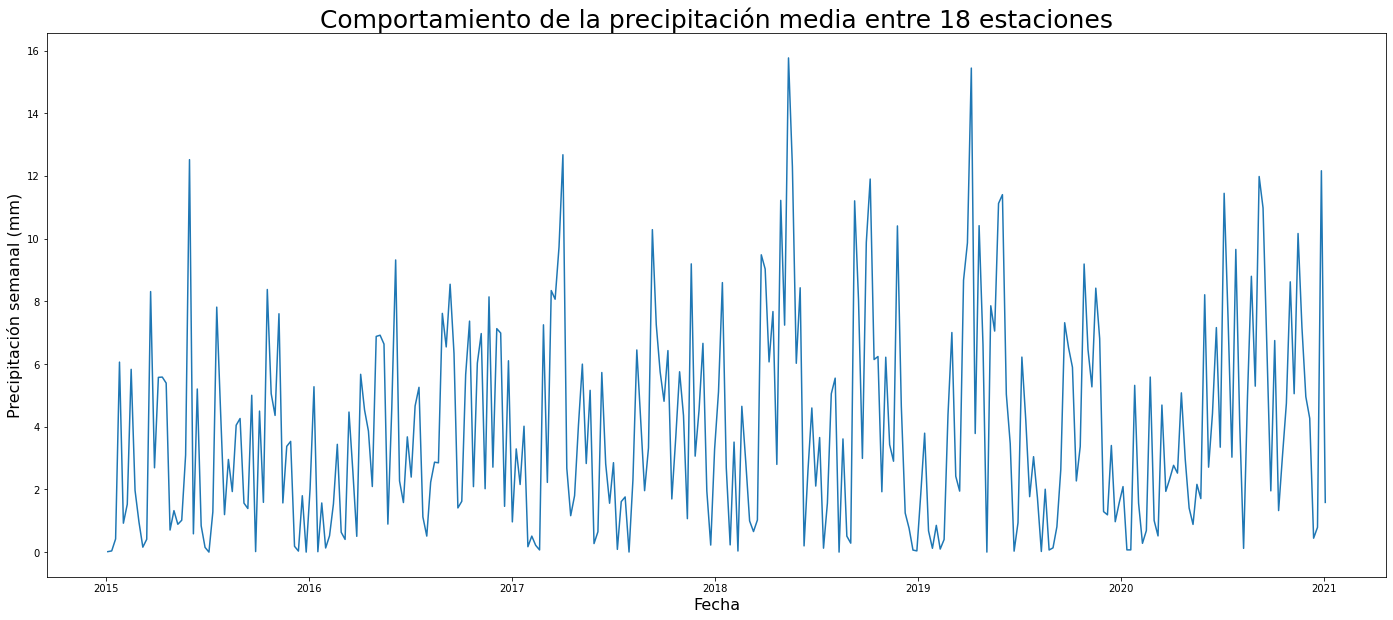

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24,10))
sns.lineplot(data=precipitacion, x = 'fecha_hora', y ='P_mean')
plt.ylabel('Precipitación semanal (mm)',size=16)
plt.xlabel('Fecha',size=16)
plt.title('Comportamiento de la precipitación media entre 18 estaciones',fontsize=25)

In [437]:
print(precipitacion.head())
print(f"Tenemos {precipitacion.shape[0]} observaciones")

                P_sum    P_mean      P_std
fecha_hora                                
2015-01-04   0.057563  0.014391   0.028781
2015-01-11   0.262833  0.037548   0.099342
2015-01-18   2.935111  0.419302   0.847961
2015-01-25  42.427667  6.061095  11.763203
2015-02-01   6.434667  0.921926   1.667757
Tenemos 314 observaciones


In [422]:
#precipitacion.to_csv('precipitacion_semanal.csv',index=False)

___
### 2.2) TEMPERATURA
___

Se siguen los mismos pasos que en la precipitación, a diferencia que en estos datos no hay archivos con 3 o 4 columnas, todos están con 3

In [12]:
%%time

#Definir la ruta de los datos:
ruta_proyecto = os.getcwd() + "\\SIATA_downloads\\temp"
#Lista de los archivos csv
lista_temperatura = os.listdir(ruta_proyecto)
#El data frame que recibirá todos los data_frames
temperaturas_todas = pd.DataFrame()

#Corremos el for
for archivo in lista_temperatura:
    # Necesitamos la dirección concreta de cada archivo CSV para ser abierto:
    csv = (ruta_proyecto + "\\" + archivo)
    
    #Extraemos el número de la estación
    estacion = int(archivo.split("_")[3])
    
    #Leemos el archivo csv
    data_frame = pd.read_csv(csv, encoding='utf-8')
    
    #Se debe definir esta condición para no iterar sobre archivos vacíos
    if data_frame.shape[0] != 0:        
        #Ejecutamos la limpieza
        data_frame.dropna(inplace=True)  
        data_frame = data_frame[(~data_frame.Calidad.isin([151,152,2])) & (data_frame.Temperatura != -999)]
        data_frame['fecha_hora'] = pd.to_datetime(data_frame.fecha_hora)
        data_frame.drop('Calidad',axis = 1, inplace = True)
        
        #Resampleamos:
        data2 = data_frame.resample('D', on = 'fecha_hora').agg(['max','min','mean']).reset_index().dropna()
        #Eliminamos este data_frame para no ocupar más espacio
        del data_frame
        #Dividimos el multiíndice
        data2.columns = ['_'.join(col) for col in data2.columns.values]
        #Agregamos la estación
        data2['codigo'] = estacion
        #Concatenamos el csv final
        temperaturas_todas = pd.concat([temperaturas_todas.reset_index(drop=True), data2], axis=0)

Wall time: 1min 15s


In [13]:
print(temperaturas_todas.shape)
temperaturas_todas.head()
#Esta información es muy valiosa y será guardada como un csv para más adelante:
#temperaturas_todas.to_csv('temperatura_2010-2020.csv',index=False)

(30216, 5)


,fecha_hora_,Temperatura_max,Temperatura_min,Temperatura_mean,codigo
0,2012-01-04,22.5,21.6,22.031579,201
1,2012-12-28,27.8,21.0,24.522432,201
2,2012-12-29,28.8,17.9,22.487083,201
3,2012-12-30,26.4,18.5,21.661875,201
4,2012-12-31,27.6,18.1,22.367191,201


Con la base de datos guardada, le asignamos el mismo nombre a la lectura del CSV. Ahora el objetivo es tener la misma resolución que el dengue, es decir mensual. Para ello es necesario correr un for donde se separe cada data_set por su código único y obtener un resampleo mensual donde se promedien las diferentes temperaturas.

In [14]:
temp_raw = pd.read_csv('temperatura_2010-2020.csv', encoding = 'utf-8')
temp_raw['fecha_hora_'] = pd.to_datetime(temp_raw.fecha_hora_)

El siguiente FOR tiene incrustado un gráfico opcional para verificar la integridad de los datos.
Como se observa, hay unas estaciones con problemas. Al parecer se estabilizan luego del 2014, e incluso algunas siguen teniendo problemas.
## **¿Qué hacer?**
Sacaré los datos desde 2015!

In [15]:
%%time

temp_raw = temp_raw[(temp_raw.fecha_hora_ >= '2015')]

temp_mensual = pd.DataFrame()
for estacion in temp_raw.codigo.unique():
    #Separar por estación el set de datos:
    data = temp_raw[temp_raw.codigo == estacion]
    #Resamplear esa estación
    data2 = data.resample('W', on = 'fecha_hora_').agg(['mean','std']).reset_index()
    del data
        
    #Eliminar cualquier valor faltante:
    data2.dropna(inplace=True)
    #Cambiar los multiíndices:
    data2.columns = ['_'.join(col) for col in data2.columns.values]
    ################################################################################################
    #plt.figure(figsize=(24,10))
    #sns.lineplot(data=data2, x = 'fecha_hora__', y ='Temperatura_mean_mean')
    #plt.ylabel('Temperatura mensual media (°C)',size=16)
    #plt.xlabel('Fecha',size=16)
    #plt.vlines(x=pd.to_datetime('2015-01-01'),ymin=np.min(data2.Temperatura_mean_mean),ymax=np.max(data2.Temperatura_mean_mean),colors='red')
    #plt.title('Comportamiento de la Temperatura media en la estacion '+str(estacion),fontsize=25)
    #################################################################################################
    #Concatenar a la base de datos grande
    temp_mensual = pd.concat([temp_mensual.reset_index(drop=True), data2], axis=0)

##Arreglo de las columnas
temp_mensual.drop(['codigo_std'],axis=1,inplace=True)
temp_mensual.rename(columns = {'fecha_hora__':'fecha_hora',
                              'codigo_mean':'codigo'},inplace=True)

Wall time: 178 ms


In [16]:
temperatura = temp_mensual.resample('W', on = 'fecha_hora').mean().reset_index().drop('codigo',axis=1)

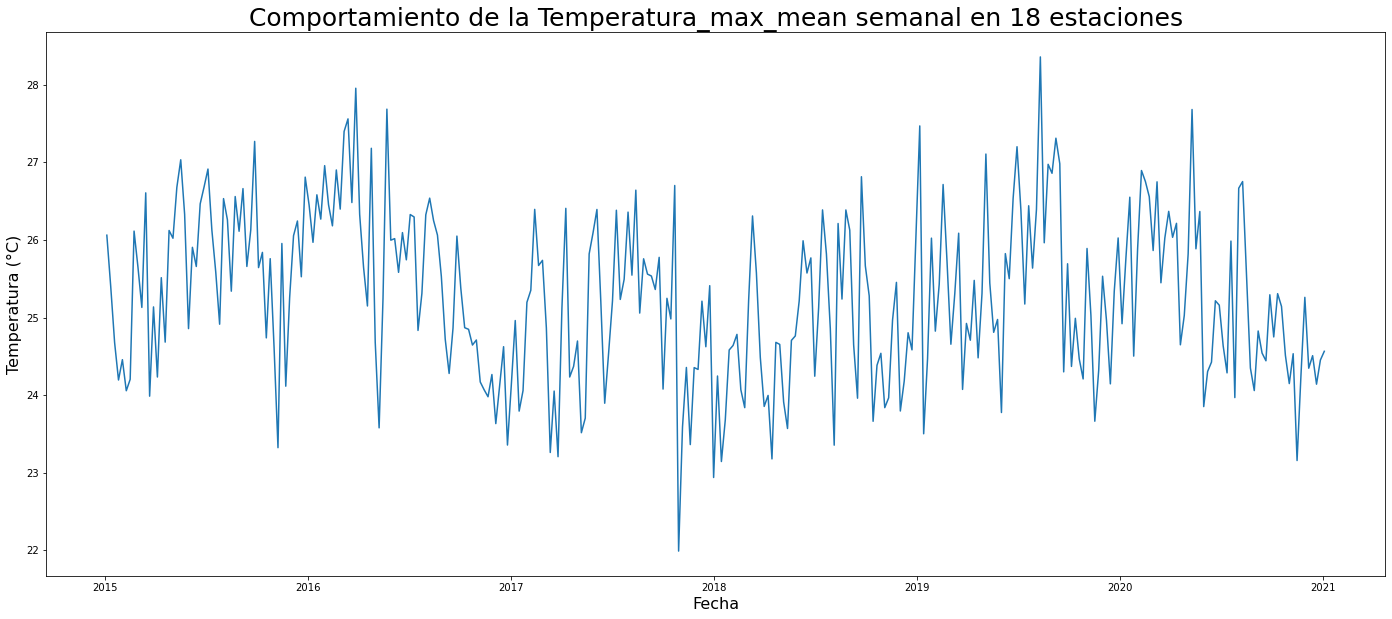

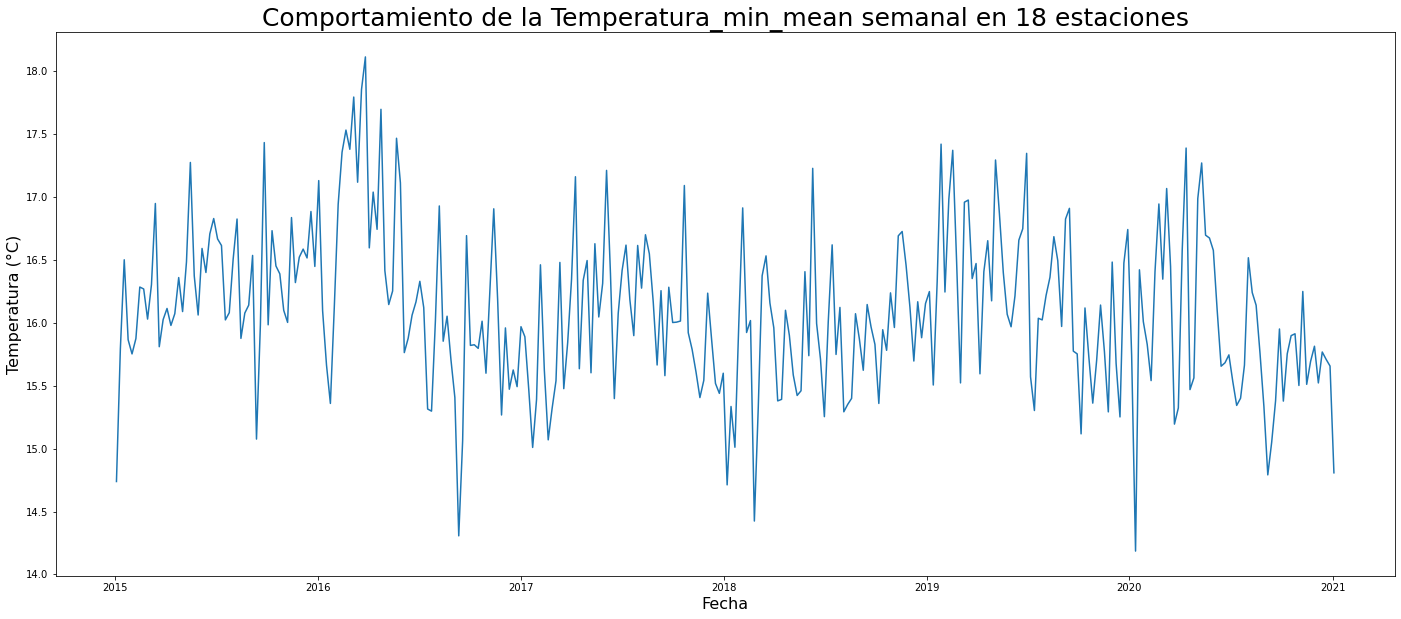

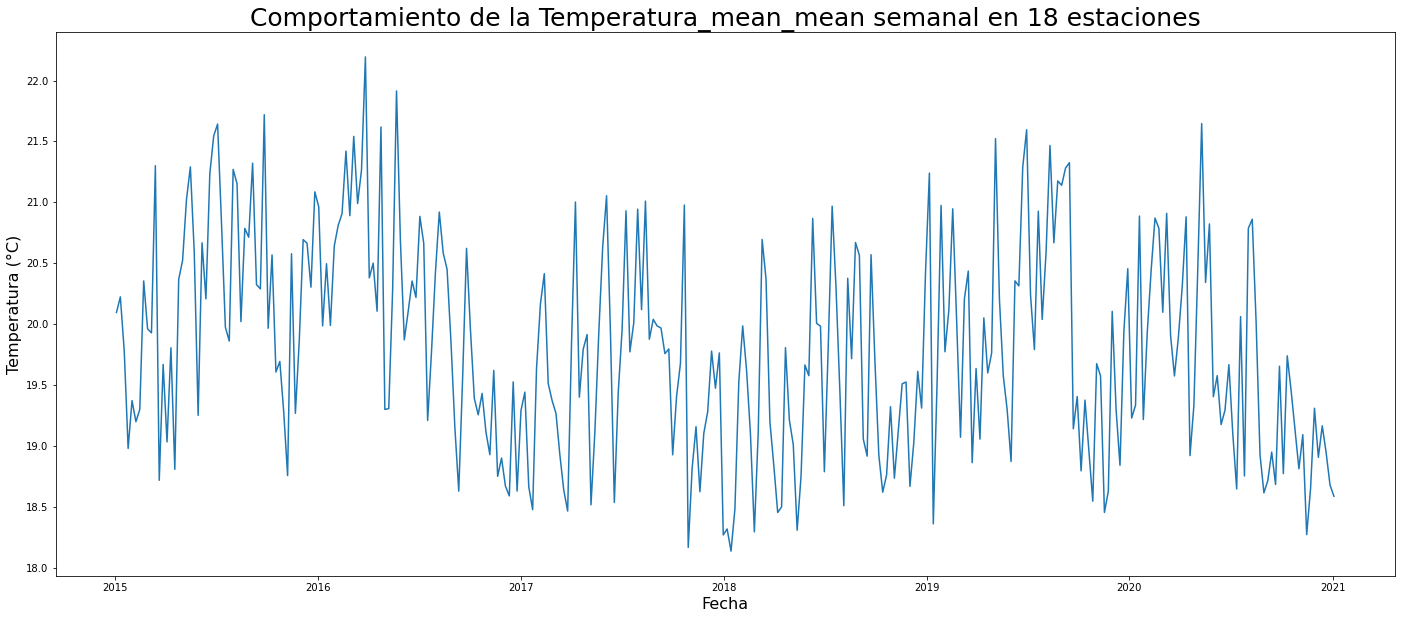

In [17]:
tipos_temp = ['Temperatura_max_mean','Temperatura_min_mean','Temperatura_mean_mean']
for temps in tipos_temp:
    plt.figure(figsize=(24,10))
    sns.lineplot(data=temperatura, x = 'fecha_hora', y =temps)
    plt.ylabel('Temperatura (°C)',size=16)
    plt.xlabel('Fecha',size=16)
    plt.title('Comportamiento de la '+ temps + " semanal en 18 estaciones",fontsize=25)

In [18]:
print(temperatura.head())
print(f"Tenemos {temperatura.shape[0]} observaciones")

  fecha_hora  Temperatura_max_mean  Temperatura_max_std  Temperatura_min_mean  \
0 2015-01-04             26.060000             0.697236             14.738333   
1 2015-01-11             25.398312             1.074233             15.789610   
2 2015-01-18             24.676299             1.037496             16.499675   
3 2015-01-25             24.195455             1.139306             15.864286   
4 2015-02-01             24.457143             1.545028             15.751948   

   Temperatura_min_std  Temperatura_mean_mean  Temperatura_mean_std  
0             1.338313              20.094824              0.284460  
1             1.250647              20.223201              0.911569  
2             0.638458              19.778191              0.689741  
3             0.877756              18.978301              0.687984  
4             0.905225              19.371267              0.875901  
Tenemos 314 observaciones


In [430]:
#temperatura.to_csv('temperatura_semanal.csv',index=False)

___
## SECCIÓN 3) DATOS DISPONIBLES:
___

___
### 3.1) PRECIPITACIÓN Y TEMPERATURA:
___

Al momento tenemos los siguientes datos obtenidos del SIATA:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

temperatura = pd.read_csv('temperatura_semanal.csv',encoding="utf'8",parse_dates = ['fecha_hora'], index_col='fecha_hora')
precipitacion = pd.read_csv('precipitacion_semanal.csv',encoding="utf'8",parse_dates = ['fecha_hora'], index_col='fecha_hora')

In [2]:
temperatura.head()

,Temperatura_max_mean,Temperatura_max_std,Temperatura_min_mean,Temperatura_min_std,Temperatura_mean_mean,Temperatura_mean_std
fecha_hora,,,,,,
2015-01-04,26.060000,0.697236,14.738333,1.338313,20.094824,0.284460
2015-01-11,25.398312,1.074233,15.789610,1.250647,20.223201,0.911569
2015-01-18,24.676299,1.037496,16.499675,0.638458,19.778191,0.689741
2015-01-25,24.195455,1.139306,15.864286,0.877756,18.978301,0.687984
2015-02-01,24.457143,1.545028,15.751948,0.905225,19.371267,0.875901


In [3]:
precipitacion.head()

,P_sum,P_mean,P_std
fecha_hora,,,
2015-01-04,0.057563,0.014391,0.028781
2015-01-11,0.262833,0.037548,0.099342
2015-01-18,2.935111,0.419302,0.847961
2015-01-25,42.427667,6.061095,11.763203
2015-02-01,6.434667,0.921926,1.667757


___
### 3.2) DENGUE:
___

Vuelvo a traer los datos de dengue, la siguiente rutina está hecha en el TP3, acá se realiza rapidamente para obtener la base de datos "limpia", en este caso es necesario eliminar las comunas rurales que son 5 (Altavista, San Cristobal, Santa Elena, San Antonio de Prado y Palmitas):

In [4]:
%%time
import warnings
warnings.filterwarnings('ignore')
url_dengue = "http://medata.gov.co/node/19391/download"
dengue_raw = pd.read_csv(url_dengue,encoding='utf-8',delimiter=";")
#Para corregir un poco el nombre de las columnas:
columnas = []
for i, elemnt in enumerate(dengue_raw.columns):
    columnas.append(elemnt.split(".")[1])
dengue_raw.columns = columnas

#Partir la fecha de contagios en columnas independientes y que sean numéricas para ver su distribución
dengue_raw[['dia','mes','año']] = dengue_raw.fec_con_.str.split("/",expand=True)

#Pasar el año a string
dengue_raw['y_string'] = (dengue_raw['year_']).astype(str)

#Agregarlos en un objeto
dates=dengue_raw[['y_string', 'mes', 'dia']].agg('-'.join, axis=1)

#Pegarlos como fecha en `date`
dengue_raw['date']= pd.to_datetime(dates)

#Primero pasaré `nombre_barrio` y `comuna` a mayúscula sostenida y remplazaré cualquier caracter especial por su homónimo:
caracteres_especiales = {'Á':'A','É':'E','Í':'I','Ó':'O','Ú':'U','Ñ':'N'}

for i,j in caracteres_especiales.items():
    dengue_raw['comuna'] = dengue_raw['comuna'].str.upper().str.replace(i,j)
    dengue_raw['nombre_barrio'] = dengue_raw['nombre_barrio'].str.upper().str.replace(i,j)

#Quitar los que no tienen información "espacial"
dengue_raw2 = dengue_raw.loc[(dengue_raw['nombre_barrio'] != 'SIN INFORMACION') & (dengue_raw['comuna'] != 'SIN INFORMACION')]
#Quitar la edad superior a 100 años
dengue_raw3 = dengue_raw2.loc[dengue_raw['edad_'] < 100]
#Escoger las variables deseadas
dengue_tidy = dengue_raw3.iloc[:,[42,5,6,2,4]]
#Sacar los corregimientos rurales
dengue_tidy = dengue_tidy[~dengue_tidy.comuna.isin(["CORREGIMIENTO DE SAN CRISTOBAL","SAN SEBASTIAN DE PALMITAS","CORREGIMIENTO DE SANTA ELENA","ALTAVISTA","SAN ANTONIO DE PRADO"])]

del dengue_raw, dengue_raw2, dengue_raw3

dengue_tidy['casos'] = 1
dengue_semanal = dengue_tidy.drop('edad_',axis=1).resample('D',on = 'date').sum().reset_index().resample('W',on ='date').agg(['sum','mean','std']).reset_index()
#El multiíndice se pasa a un índice sencillo
dengue_semanal.columns = ['_'.join(col) for col in dengue_semanal.columns.values]
dengue_semanal.rename(columns = {'date_':'fecha_hora'},inplace=True)
dengue_semanal.set_index('fecha_hora',inplace=True)

Wall time: 14.9 s


Así tenemos dos dataset `dengue_tidy` está el resumen para cada barrio o comuna a resolución diaria y `dengue_semanal` donde se ha hecho el resampleo general a nivel semanal

In [5]:
dengue_tidy.head()

,date,nombre_barrio,comuna,edad_,sexo_,casos
0,2010-06-19,BELEN,BELEN,49.0,M,1
1,2010-06-18,BELEN,BELEN,47.0,M,1
2,2010-06-21,SUCRE,VILLA HERMOSA,46.0,M,1
4,2010-06-20,PERPETUO SOCORRO,LA CANDELARIA,46.0,M,1
5,2010-06-17,TERMINAL DE TRANSPORTE,CASTILLA,45.0,M,1


In [6]:
dengue_semanal.head()

,casos_sum,casos_mean,casos_std
fecha_hora,,,
2008-01-06,15,3.000000,2.828427
2008-01-13,18,2.571429,1.397276
2008-01-20,22,3.142857,2.544836
2008-01-27,28,4.000000,1.527525
2008-02-03,14,2.000000,1.000000


Dado que los datos de precipitación y temperatura están desde 2015 es necesario recortar:

In [7]:
dengue_semanal = dengue_semanal[dengue_semanal.index.year >= 2015]
print(f"La variable de precipitacion tiene {precipitacion.shape[0]} observaciones, temperatura {temperatura.shape[0]} y el dengue {dengue_semanal.shape[0]}")
print(f"Recordar que dengue tiene un intervalo entre {dengue_semanal.index.year.min()} y {dengue_semanal.index.year.max()}, mientras precipitación y temperatura entre {temperatura.index.year.min()}-{temperatura.index.year.max()}")
print("Los valores de precipitación y temperatura entre 2019-2021 pueden ser útiles para predicir!")

La variable de precipitacion tiene 314 observaciones, temperatura 314 y el dengue 209
Recordar que dengue tiene un intervalo entre 2015 y 2018, mientras precipitación y temperatura entre 2015-2021
Los valores de precipitación y temperatura entre 2019-2021 pueden ser útiles para predicir!


___
Es menester crear una base de datos donde se agrupen todas las variables (así más adelante se vuelvan a partir para el machine learning)

In [8]:
agrupacion = pd.concat([dengue_semanal,precipitacion,temperatura],axis=1)#Fíjese que se conservan las 209 observaciones indiciales de dengue y el dropna bota aquellas donde no hay valores. Con esto tenemos para entrenar un modelo!
agrupacion.head()

,casos_sum,casos_mean,casos_std,P_sum,P_mean,P_std,Temperatura_max_mean,Temperatura_max_std,Temperatura_min_mean,Temperatura_min_std,Temperatura_mean_mean,Temperatura_mean_std
fecha_hora,,,,,,,,,,,,
2015-01-04,145.0,20.714286,12.120427,0.057563,0.014391,0.028781,26.060000,0.697236,14.738333,1.338313,20.094824,0.284460
2015-01-11,168.0,24.000000,9.018500,0.262833,0.037548,0.099342,25.398312,1.074233,15.789610,1.250647,20.223201,0.911569
2015-01-18,79.0,11.285714,5.219013,2.935111,0.419302,0.847961,24.676299,1.037496,16.499675,0.638458,19.778191,0.689741
2015-01-25,62.0,8.857143,4.598136,42.427667,6.061095,11.763203,24.195455,1.139306,15.864286,0.877756,18.978301,0.687984
2015-02-01,47.0,6.714286,2.690371,6.434667,0.921926,1.667757,24.457143,1.545028,15.751948,0.905225,19.371267,0.875901


___
## SECCIÓN 4) DISEÑO DE FEATURES, CORRELACIONES Y MACHINE LEARNING:
___

___
### 4.1) DISEÑO DE FEATURES & CORRELACIONES
___

In [9]:
agrupacion.head()

,casos_sum,casos_mean,casos_std,P_sum,P_mean,P_std,Temperatura_max_mean,Temperatura_max_std,Temperatura_min_mean,Temperatura_min_std,Temperatura_mean_mean,Temperatura_mean_std
fecha_hora,,,,,,,,,,,,
2015-01-04,145.0,20.714286,12.120427,0.057563,0.014391,0.028781,26.060000,0.697236,14.738333,1.338313,20.094824,0.284460
2015-01-11,168.0,24.000000,9.018500,0.262833,0.037548,0.099342,25.398312,1.074233,15.789610,1.250647,20.223201,0.911569
2015-01-18,79.0,11.285714,5.219013,2.935111,0.419302,0.847961,24.676299,1.037496,16.499675,0.638458,19.778191,0.689741
2015-01-25,62.0,8.857143,4.598136,42.427667,6.061095,11.763203,24.195455,1.139306,15.864286,0.877756,18.978301,0.687984
2015-02-01,47.0,6.714286,2.690371,6.434667,0.921926,1.667757,24.457143,1.545028,15.751948,0.905225,19.371267,0.875901


De las variables disponibles es posible realizar algunas transformaciones:

* `casos_sum` se dejará como está pues será nuestra etiqueta a predecir, la suma de los casos semanales de Dengue. Por lo que se puede desechar la media y la desviación estándar.
* `P_sum` será estandarizado entre min y max para obtener valores entre 0 y 1.
* `Temperatura_mean_mean` será estandarizada igualmente que la precipitación.
* Con `Temperatura_max_mean` y `Temperatura_min_mean` se calculará `Temp_dif` que será la diferencia de las temperaturas max y mínima, para luego ser estandarizada entre 0 y 1.
* Todas las demás variables serán eliminadas

A continuación llevamos a realización el pseudocódigo anterior:

In [10]:
agrupacion['P_normalize'] = (agrupacion.P_sum-agrupacion.P_sum.min())/(agrupacion.P_sum.max()-agrupacion.P_sum.min())
agrupacion['Temp_dif'] = agrupacion.Temperatura_max_mean - agrupacion.Temperatura_min_mean
agrupacion['T_dif_normalize'] = (agrupacion.Temp_dif-agrupacion.Temp_dif.min())/(agrupacion.Temp_dif.max()-agrupacion.Temp_dif.min())
agrupacion['T_media_normalize'] = (agrupacion.Temperatura_mean_mean-agrupacion.Temperatura_mean_mean.min())/(agrupacion.Temperatura_mean_mean.max()-agrupacion.Temperatura_mean_mean.min())
agrupacion_semanal= agrupacion.drop(['casos_mean','casos_std','P_mean','P_std','Temperatura_max_std','Temperatura_min_std','Temperatura_mean_std','P_sum','Temperatura_max_mean','Temperatura_min_mean','Temp_dif','Temperatura_mean_mean'],axis=1)

agrupacion_semanal.head()

,casos_sum,P_normalize,T_dif_normalize,T_media_normalize
fecha_hora,,,,
2015-01-04,145.0,0.000522,0.886359,0.482824
2015-01-11,168.0,0.002382,0.597172,0.514456
2015-01-18,79.0,0.026595,0.355405,0.404806
2015-01-25,62.0,0.384437,0.381495,0.207715
2015-02-01,47.0,0.058305,0.444639,0.304541


In [11]:
agrupacion_semanal.describe()

,casos_sum,P_normalize,T_dif_normalize,T_media_normalize
count,209.000000,314.000000,314.000000,314.000000
mean,108.028708,0.249044,0.523909,0.413857
std,130.298581,0.208678,0.151978,0.214643
min,12.000000,0.000000,0.000000,0.000000
25%,22.000000,0.079499,0.426912,0.242955
50%,40.000000,0.193604,0.524940,0.403659
75%,135.000000,0.383231,0.627154,0.571042
max,557.000000,1.000000,1.000000,1.000000


In [12]:
#Borramos los valores faltantes
ML_data = agrupacion_semanal.dropna()

casos_sum


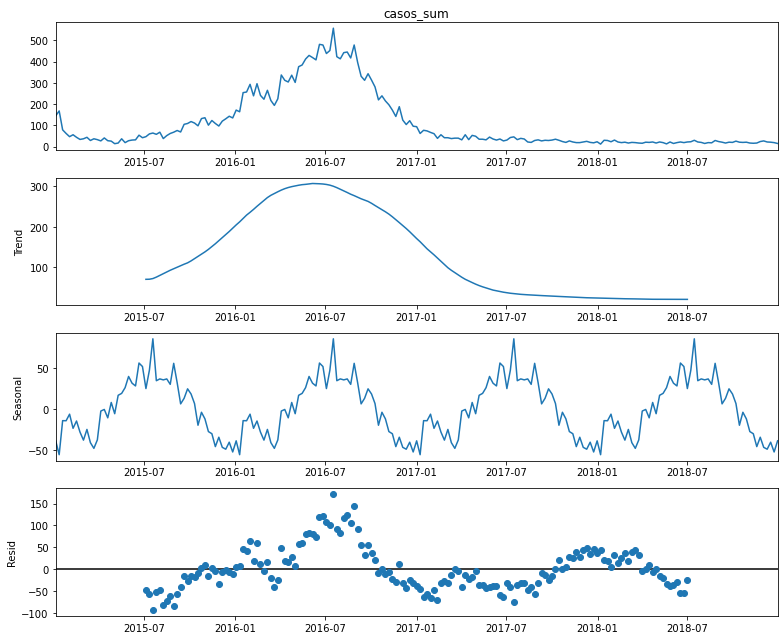




P_normalize


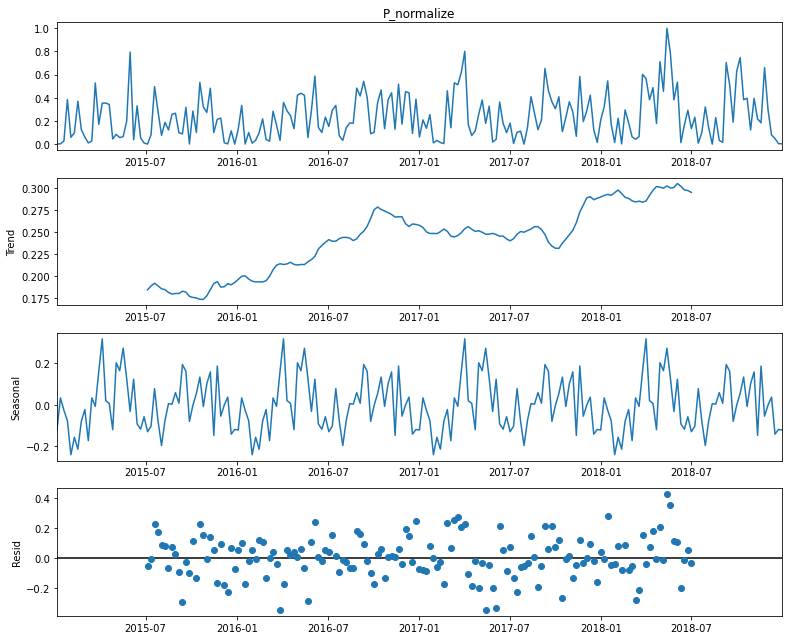




T_dif_normalize


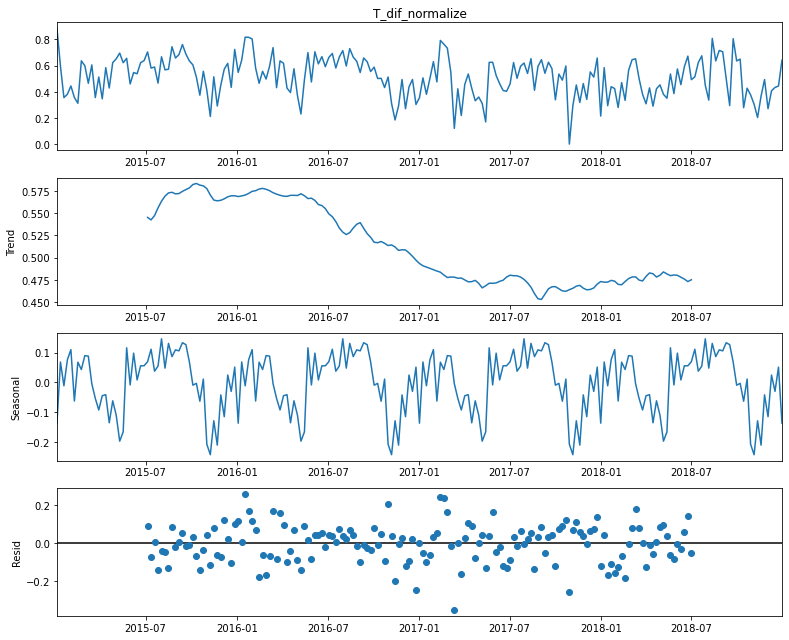




T_media_normalize


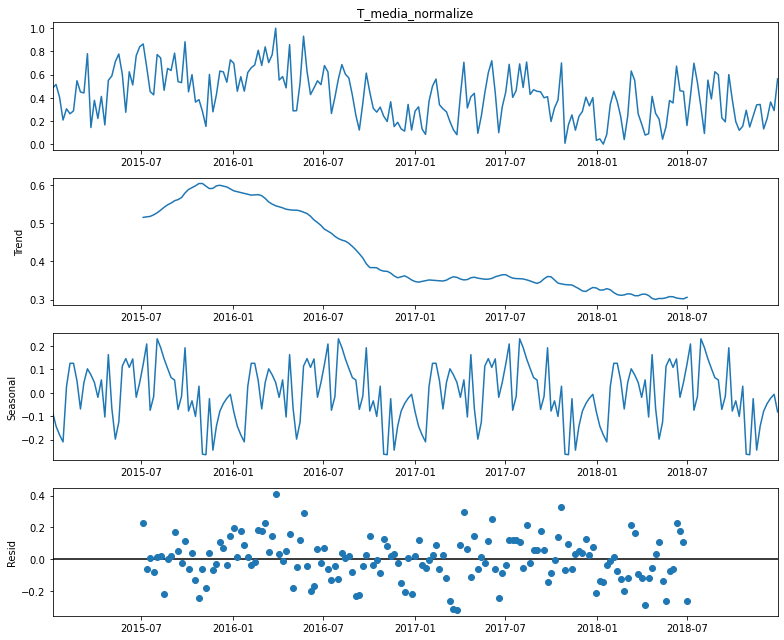

In [13]:
#Graficamos el comportamiento temporal de cada variable:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11,9
#Lo descompondremos a nivel mensual:
for i in ML_data.columns:
    print(i)
    decomposition = sm.tsa.seasonal_decompose(ML_data[i] ,model='additive')
    fig= decomposition.plot()
    plt.show()
    print("\n\n")

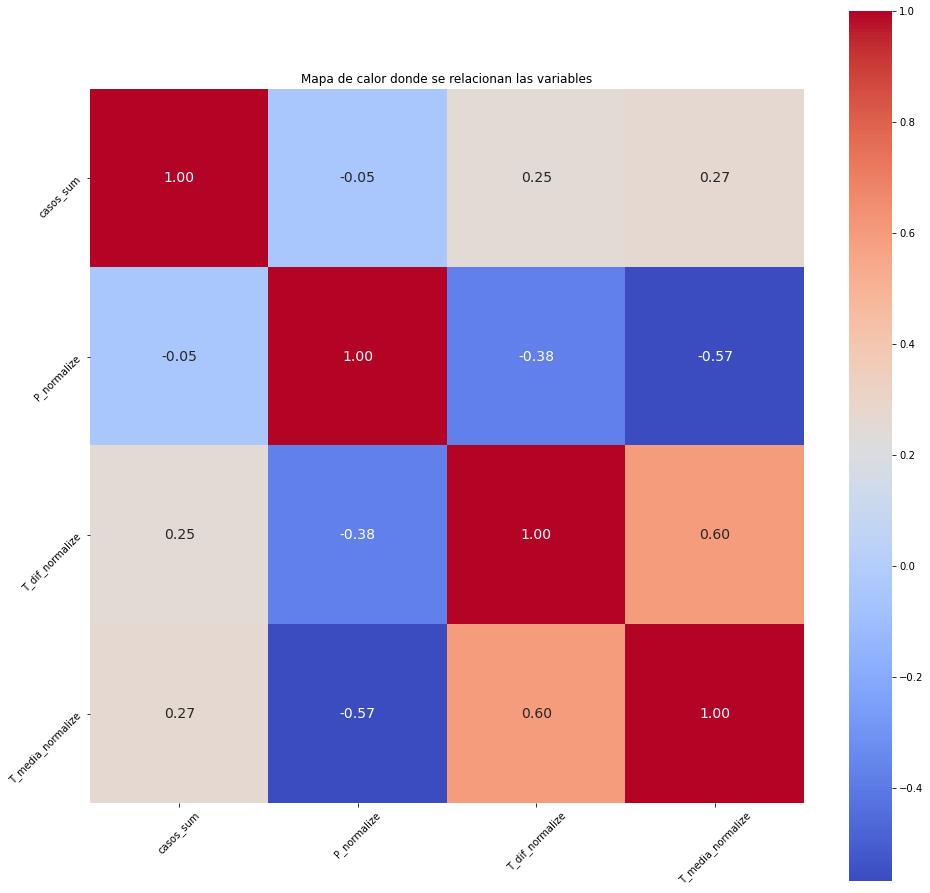

In [14]:
#Hagamos la matriz de correlación:

matriz_correlacion = agrupacion_semanal.corr()
matriz_correlacion 

plt.figure(figsize=(16,16))
sns.heatmap(matriz_correlacion, cbar = True,  square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, cmap = 'coolwarm')
plt.title('Mapa de calor donde se relacionan las variables')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Al interpretar la gráfica, recordemos que la variable a predecir es `casos_sum`. Esta tiene una correlación positiva con la temperatura media semanal y la diferencia de temperaturas. Mientras con la precipitación parece tener una diminuta correlación negativa

___
### 4.2) MACHINE LEARNING
___

Las siguientes líneas de código tienen como propósito realizar un modelo de benchmark (persistencia) donde la observación anterior predice la siguiente, luego una red neuronal LSTM univariada, y finalmente la red LSTM multivariada.

Vale la pena reconocer el apoyo de los siguientes enlaces para llevar a cabo el procedimiento:

* [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
* [Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

Ajustar redes neuronales no es una tarea sencilla, y mucho menos en series de tiempo; sería necesario tener un conocimiento profundo de cálculo, álgebra lineal, estadística y ciencias de la computación. Se espera explicar de manera sencilla como se realizó el montaje del modelo sin entrar en detalles técnicos.
____

#### 4.2.1) MODELO BENCHMARK (DE PERSISTENCIA)
____

El modelo más sencillo de referencia es aquel que predice el valor de la semana siguiente con base en el valor de la semana anterior. Este será nuestro modelo benchmark. En este caso el modelo se construirá únicamente con los casos, el RMSE será nuestra métrica de referencia:

RMSE: 8.147


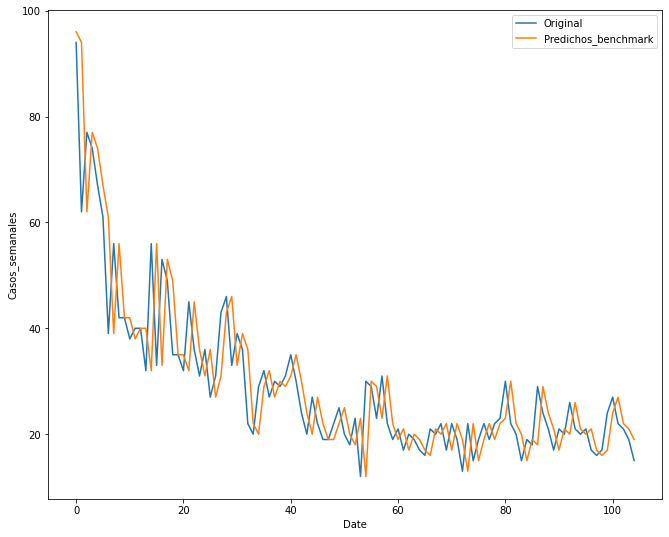

In [23]:
# Líneas de código extraídas de: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
import matplotlib.pyplot as plt

# load dataset
series_base = ML_data.casos_sum
# split data into train and test
X_base = series_base.values
# Estos datos van desde 2015 a 2016
train_base, test_base = X_base[0:-105], X_base[-105:]
# walk-forward validation
history = [x for x in train_base]
predictions_base = list()
for i in range(len(test_base)):
	# make prediction (el número de semanas de lag)
	predictions_base.append(history[-1])
	# observation
	history.append(test_base[i])
# report performance
rmse_base = sqrt(mse(test_base, predictions_base))
print('RMSE: %.3f' % rmse_base)
# line plot of observed vs predicted
plt.plot(test_base, label='Original')
plt.plot(predictions_base, label= 'Predichos_benchmark')
plt.xlabel('Date')
plt.ylabel('Casos_semanales')
plt.legend()
plt.show()

In [276]:
print("El modelo recurrente tiene un RMSE de %.3f. Esto para un lag de 1 semana. Será un punto de referencia para los demás modelos" % rmse)

El modelo recurrente tiene un RMSE de 8.147. Esto para un lag de 1 semana. Será un punto de referencia para los demás modelos


___
#### 4.2.2) PREPROCESAMIENTO PARA LSTM UNIVARIADA
____

Para entrenar una red neuronal LSTM es necesario tener una base de datos estructurada y congruente con el tipo de modelo. Es necesario realizar los siguientes pasos:

1. Transformar la serie de tiempo en un problema de regresión supervisada.
1. Volver la serie de tiempo en una serie estacional
1. Escalar los datos

___
##### 4.2.2.1) SERIE DE TIEMPO A PROBLEMA DE APRENDIZAJE SUPERVISADO
____

La siguiente función permite transformar una serie univariada de tiempo a un data frame para Machine Learning:

In [26]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

___
##### 4.2.2.2) SERIE DE TIEMPO ESTACIONARIA
____

Las series de tiempo estacionarias son más sencillas de modelar. Es posible extraer la tendencia y nuevo añadirsela. Por lo que se requieren dos funciones. Una que remueva la tendencia y otra que la añada. Una forma de hacerlo es la observacion anterior (t-1) se resta a la observación actual (t). Esto elimina la tendencia y queda una serie diferenciada. Las siguientes dos funciones hacen eso:

In [27]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

___
##### 4.2.2.3) ESCALADO DE LOS DATOS
____

Como otras redes neuronales, las LSTM esperan datos que esten en la escala de activación, en este caso se recomienda -1 y 1. Se usa el escalador de scikit-learn:

In [28]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]	
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

___
##### 4.2.2.4) AJUSTE DE RED NEURONAL LSTM
____

Extraído de: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Las capas de LSTM esperan una matriz de entrada con las dimensiones: [samples,time steps, features]

* **Samples**: Filas del dataset
* **Time steps**: Estos son pasos de tiempo separados de una variable dada para una observación dada. 
* **Features**: Estas son medidas separadas que se observan en el momento de la observación.

El tamaño del 'batch' (lotes) es por lo general menor que el número de muestras. Esta, junto con 'epochs', define que tan rápido la red neuronal aprende de los datos (cada cuánto se actualizan los pesos).

El último parámetro para el LSTM es el número de neuronas, también llamado el numero de memorias o bloques. Entre 1 a 5 es suficiente.

Una vez la red esté especificada debe ser compilada. Allí se debe especificar una función de pérdida y optimización del algoritmo. MSE será la función de périda y la optimización ADAM

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
    #Definir el número de neuronas
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    #UNA DE SALIDA
	model.add(Dense(1,activation='sigmoid'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

___
##### 4.2.2.5) PREDICCIONES
____

La función permite obtener las predicciones para el modelo entrenado anteriormente:

In [30]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

___
#### 4.2.3) DESARROLLO DE  RED NEURONAL LSTM UNIVARIADA
____

El siguiente código entrena la red neuronal con un batch de 1, 1500 epoch y 1 neurona.

In [35]:
%%time
#Extraído de: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

#load dataset
series = ML_data.casos_sum
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-105], supervised_values[-105:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse_uni = sqrt(mse(raw_values[-105:], predictions))
print('Test RMSE: %.3f' % rmse)

Week=1, Predicted=103.802416, Expected=94.000000
Week=2, Predicted=98.249135, Expected=62.000000
Week=3, Predicted=69.974549, Expected=77.000000
Week=4, Predicted=75.263580, Expected=74.000000
Week=5, Predicted=79.058038, Expected=67.000000
Week=6, Predicted=72.489412, Expected=61.000000
Week=7, Predicted=66.273144, Expected=39.000000
Week=8, Predicted=46.398765, Expected=56.000000
Week=9, Predicted=53.471872, Expected=42.000000
Week=10, Predicted=48.857325, Expected=42.000000
Week=11, Predicted=45.765613, Expected=38.000000
Week=12, Predicted=42.930582, Expected=40.000000
Week=13, Predicted=43.307189, Expected=40.000000
Week=14, Predicted=43.979187, Expected=32.000000
Week=15, Predicted=37.720175, Expected=56.000000
Week=16, Predicted=50.789819, Expected=33.000000
Week=17, Predicted=40.698245, Expected=53.000000
Week=18, Predicted=49.204003, Expected=49.000000
Week=19, Predicted=54.432455, Expected=35.000000
Week=20, Predicted=41.586699, Expected=35.000000
Week=21, Predicted=38.780811

Test RMSE: 8.825


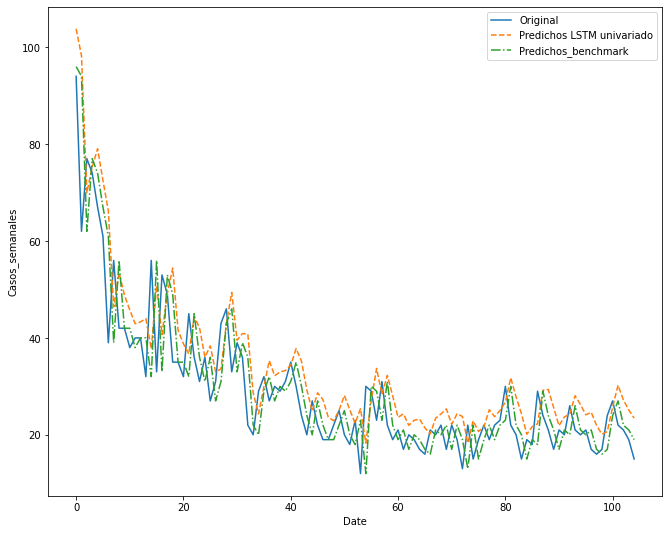

In [86]:
# report performance
rmse_uni = sqrt(mse(raw_values[-105:], predictions))
print('Test RMSE: %.3f' % rmse_uni)
# line plot of observed vs predicted
plt.plot(raw_values[-105:],label='Original')
plt.plot(predictions, '--',label= 'Predichos LSTM univariado')
plt.plot(predictions_base,'-.', label= 'Predichos_benchmark')
plt.xlabel('Date')
plt.ylabel('Casos_semanales')
plt.legend()
plt.show()

In [87]:
print("Se observa que el RMSE en la red neuronal es de %.3f, \
mientras el benchmark fué de %.3f. \
Es de esperar que el benchmark recurrente sea mejor, pues simplemente está desplazando las observaciones una semana, \
Mientras la red realiza un aprendizaje de los datos y tiene un proceso más elaborado, \
a continuación se realizará una nueva red neuronal teniendo en cuenta las nuevas variables descargadas" % (rmse_uni,rmse_base))

Se observa que el RMSE en la red neuronal es de 8.825, mientras el benchmark fué de 8.147. Es de esperar que el benchmark recurrente sea mejor, pues simplemente está desplazando las observaciones una semana, Mientras la red realiza un aprendizaje de los datos y tiene un proceso más elaborado, a continuación se realizará una nueva red neuronal teniendo en cuenta las nuevas variables descargadas


___
#### 4.2.4) DESARROLLO DE  RED NEURONAL LSTM MULTIVARIADA
____

Tomado de: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

El montaje de la red neuornal es muy similar. La diferencia es que en este caso los inputs serán los lags de las diferentes variables (incluyendo la variable a predecir). Se espera que este modelo sea mejor ajustado, recordar que es necesario hacer unos preprocesamientos. Vamos a ello:

___
##### 4.2.4.1) CONVERTIR SERIE DE TIEMPO A PROBLEMA DE APRENDIZAJE SUPERVISADO
____

In [39]:
#Extraído de un comentario de: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
#Esta función convierte una serie de tiempo en un problema de clasificación supervisada:

from pandas import DataFrame
from pandas import concat
import random
 
def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [55]:
#Correr la función previamente definida
reframed = time_series_to_supervised(ML_data,1,0)
#Drop las variables que no son útiles para el modelado:
reframed.drop(reframed.columns[[1,2,3]], axis=1,inplace=True)
#La organización necesaria para las funciones
reframed=reframed[reframed.columns[[1,2,3,4,0]]]
print(reframed.shape)
reframed.head()
#Recordemos que al hacer el lag la primera observación (o el número de desplazamientos se pierde —queda en NaN)
#las variables también están escaladas de 0 a 1 por lo que podemos proceder con la definición y ajuste del modelo

(208, 5)


,casos_sum(t-1),P_normalize(t-1),T_dif_normalize(t-1),T_media_normalize(t-1),casos_sum
fecha_hora,,,,,
2015-01-11,145.0,0.000522,0.886359,0.482824,168.0
2015-01-18,168.0,0.002382,0.597172,0.514456,79.0
2015-01-25,79.0,0.026595,0.355405,0.404806,62.0
2015-02-01,62.0,0.384437,0.381495,0.207715,47.0
2015-02-08,47.0,0.058305,0.444639,0.304541,56.0


___
##### 4.2.4.1) SET DE ENTRENAMIENTO Y TESTEO
____

In [75]:
# split into train and test sets
values = reframed.values
#Definir las semanas de entrenamiento. Dado que anteriormente eran 105 semanas de test, el train serían 104, y como se pierde la primera observación son 103
n_train_weeks = 103
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(103, 1, 4) (103,) (105, 1, 4) (105,)


___
##### 4.2.4.1) DEFINIR EL MODELO LSTM
____

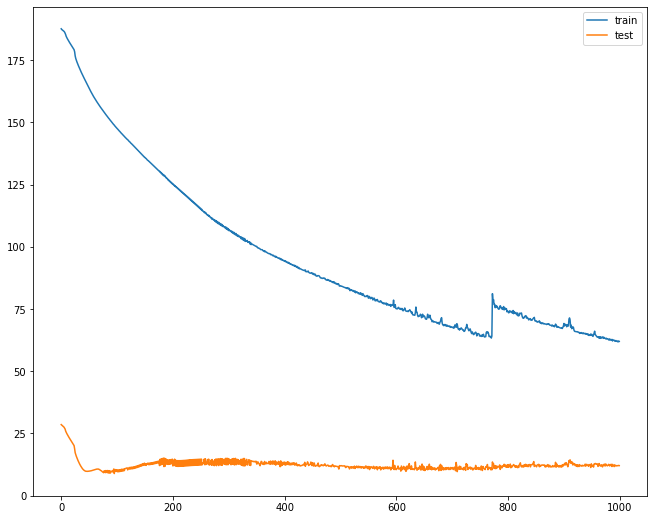

Wall time: 2min 1s


In [91]:
%%time
# design network
model = Sequential()
#Esta vez entrenaremos el modelo con 5 neuronas
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=1, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

___
##### 4.2.4.1) TESTEAR EL MODELO
____

In [96]:
# make a prediction
yhat = model.predict(test_X)
rmse_multi = sqrt(mse(test_y, yhat))
print('Test RMSE: %.3f' % rmse_multi)

Test RMSE: 14.340


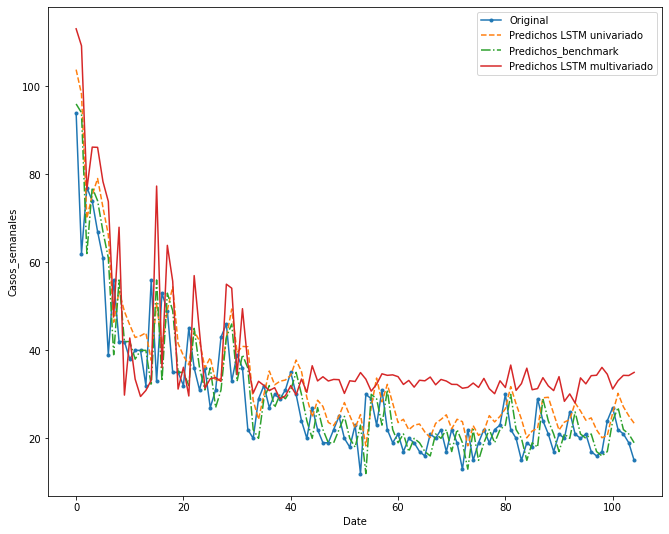

In [94]:
# line plot of observed vs predicted
plt.plot(raw_values[-105:],'.-',label='Original')
plt.plot(predictions, '--',label= 'Predichos LSTM univariado')
plt.plot(predictions_base,'-.', label= 'Predichos_benchmark')
plt.plot(yhat,'-',label='Predichos LSTM multivariado')
plt.xlabel('Date')
plt.ylabel('Casos_semanales')
plt.legend()
plt.show()

In [95]:
print("El RMSE del modelo benchmark es: %.3f. \n\
El RMSE del modelo LSTM univariado es: %.3f. \n\
El RMSE del modelo LSTM multivariado es: %.3f."% (rmse_uni,rmse_base,rmse_multi))

El RMSE del modelo benchmark es: 8.825. 
El RMSE del modelo LSTM univariado es: 8.147. 
El RMSE del modelo LSTM multivariado es: 14.340.


En este caso específico se puede concluir que incluir más variables al modelo no genera un buen ajuste. **¿Por qué?** Al agregar más features en una serie de tiempo se está generando mayor incertidumbre, por lo que entre el benchmark (recurrente) y el univariado se obtienen valores aceptables, además, en la sección correlaciones se observo una baja dependecia con la temperatura o la precipitación.

Para continuar en el tema se hace necesario profundizar en aspectos teóricos de las series de tiempo y redes neuronales, los cuales se escapan del alcance de esta carrera. No obstante el ejercicio fué bastante interaste y amerita continuar buscando ¿qué variables hidroclimáticas, sociales o económicas pueden determinar los casos de dengue en la ciudad de Medellín?

___
### 6) CONCLUSIONES
___

Llegado al final del proyecto, puedo concluir que falta mucho por aprender. El ejericio fuerte acá fué el scraping. La modelación ha quedado corta y estos datos darían para ser analizados desde muchísismas perspectivas, incluyendo la espacio-temporal. Dada la alta variabilidad del fenómeno y su ocurrencia por brotes epidémicos endémicos, se hace más compleja la modelación de los datos. Queda pendiente seguir trabajando en los datos, teniendo en cuenta el caracter temporal de los mismos.

El proyecto a mi consideración está completa para la entrega de Acámica. Muchas gracias por el tiempo de los mentores y todo el equipo de Acámica!